In [2]:
import pandas as pd

with open('./data/raw/dataset_metier.txt', 'r', encoding='utf-8', errors='ignore') as f:
    lines = f.read().splitlines()

raw = pd.DataFrame({'raw_line': lines})

raw.head()


,raw_line
0,"﻿COD_ANU,COD_ETU,COD_ELP,NOT_ELP,COD_TRE,COD_SES"
1,"2015,7847033,JFE35204,,,2"
2,"2015,7847033,JFE35304,11,V,1"
3,"2015,7847033,JFE35304,,,2"
4,"2015,381430,JFA35104,14,V,1"


In [3]:
EXPECTED_COLS = 6

def safe_split_with_status(line):
    parts = line.split(',')

    if len(parts) == EXPECTED_COLS:
        return parts + ['OK']

    if len(parts) == EXPECTED_COLS + 1:
        parts[3] = parts[3] + ',' + parts[4]
        del parts[4]
        return parts + ['FIXED']

    return [None] * EXPECTED_COLS + ['INVALID']


In [5]:
parsed = raw['raw_line'].apply(safe_split_with_status)

df = pd.DataFrame(
    parsed.tolist(),
    columns=[
        'COD_ANU',
        'COD_ETU',
        'COD_ELP',
        'NOT_ELP',
        'COD_TRE',
        'COD_SES',
        'row_status'
    ]
)

# Remove header row
df = df.iloc[1:].reset_index(drop=True)

df.head(30)


,COD_ANU,COD_ETU,COD_ELP,NOT_ELP,COD_TRE,COD_SES,row_status
0,2015,7847033,JFE35204,,,2,OK
1,2015,7847033,JFE35304,11,V,1,OK
2,2015,7847033,JFE35304,,,2,OK
3,2015,381430,JFA35104,14,V,1,OK
4,2015,381430,JFA35104,,,2,OK
5,2015,381430,JFA35304,10,V,1,OK
6,2015,381430,JFA35304,,,2,OK
7,2015,381430,JFA35404,2,RAT,1,OK
8,2015,381430,JFA35404,11,VAR,2,OK
9,2015,381430,JFA35504,10,V,1,OK


In [6]:
def completude(df):
    total = df.size
    non_empty = df.applymap(
        lambda x: pd.notna(x) and str(x).strip() != ""
    ).sum().sum()
    return non_empty / total

## cheeck done

In [7]:
def unicite(df):
    key_cols = ["COD_ETU", "COD_ELP", "COD_SES"]
    total = len(df)
    duplicates = df.duplicated(subset=key_cols).sum()
    return 1 - (duplicates / total)
## check for doblants

In [8]:
# def coherence(df):
#     incoherent = df[
#         (df["COD_SES"] == 2) & (df["NOT_ELP"].isnull())
#     ]
#     return 1 - (len(incoherent) / len(df))

def coherence(df):
    df = df.copy()

    # -------------------------
    # Rule 1: COD_TRE exists but NOT_ELP missing
    # -------------------------
    rule1 = df["COD_TRE"].notna() & df["NOT_ELP"].isna()

    # -------------------------
    # Rule 2: Session 2 exists without Session 1
    # -------------------------
    # Find (COD_ETU, COD_ELP) pairs that have session 2
    ses2 = df[df["COD_SES"] == 2][["COD_ETU", "COD_ELP"]]

    # Find pairs that have session 1
    ses1 = df[df["COD_SES"] == 1][["COD_ETU", "COD_ELP"]]

    # Pairs with session 2 but not session 1
    invalid_pairs = (
        ses2.merge(ses1, on=["COD_ETU", "COD_ELP"], how="left", indicator=True)
            .query('_merge == "left_only"')[["COD_ETU", "COD_ELP"]]
            .drop_duplicates()
    )

    # Mark incoherent rows for rule 2
    rule2 = df.merge(
        invalid_pairs,
        on=["COD_ETU", "COD_ELP"],
        how="left",
        indicator=True
    )["_merge"] == "both"

    # -------------------------
    # Combine incoherence rules
    # -------------------------
    incoherent = rule1 | rule2

    # Coherence score
    return 1 - incoherent.sum() / len(df)


In [9]:
def validite(df):
    valid_sessions = df["COD_SES"].isin(["1", "2"])
    valid_results = df["COD_TRE"].isin(["V", "RAT", "VAR", "ADM", "NV", "ACAR" , "ABS"]) | df["COD_TRE"].isnull()
    return (valid_sessions & valid_results).mean()


In [10]:
def format_score(df):
    anu_format = df["COD_ANU"].astype(str).str.match(r"^\d{4}$")
    elp_format = df["COD_ELP"].astype(str).str.match(r"^[A-Z0-9]+$")
    return (anu_format & elp_format).mean()


In [11]:
def exactitude(df):
    notes = pd.to_numeric(df["NOT_ELP"], errors="coerce")

    correct = (
        ((notes >= 0) & (notes <= 20))  # valid grade

    )

    return correct.mean()

## i removed the empty allowed condition

In [12]:
def outliers_score(df):
    notes = pd.to_numeric(df["NOT_ELP"], errors="coerce").dropna()
    q1 = notes.quantile(0.25)
    q3 = notes.quantile(0.75)
    iqr = q3 - q1
    outliers = notes[(notes < q1 - 1.5 * iqr) | (notes > q3 + 1.5 * iqr)]
    return 1 - (len(outliers) / len(notes))


In [13]:
def distribution_sessions(df):
    counts = df["COD_SES"].value_counts(normalize=True)
    return 1 - abs(counts.get(1, 0) - counts.get(2, 0))


In [14]:
# def schema_integrity(df, expected_cols=6):
#     """
#     Mesure le taux de lignes conformes au schéma attendu
#     """
#     # pandas remplit NaN mais les lignes décalées génèrent souvent des anomalies de type
#     valid_rows = df.apply(
#         lambda row: row.count() <= expected_cols,
#         axis=1
#     )
#     return valid_rows.mean()



def schema_integrity(df):
    """
    Schema integrity:
    - row_status == 'FIXED'  → invalid schema
    - anything else          → valid schema
    """
    valid_rows = df["row_status"].ne("FIXED")
    return valid_rows.mean()


In [15]:
def score_global(df):
    scores = {
        "completude": completude(df),
        "unicite": unicite(df),
        "coherence": coherence(df),
        "validite": validite(df),
        #"format": format_score(df),
        "exactitude": exactitude(df),
        #"outliers": outliers_score(df),
        "distribution": distribution_sessions(df),
        "schema_integrity": schema_integrity(df)
    }

    global_score = (
        0.20 * scores["completude"]        # very critical
        + 0.20 * scores["validite"]        # very critical
        + 0.15 * scores["exactitude"]      # very critical
        + 0.15 * scores["coherence"]       # important
        + 0.05 * scores["unicite"]         # moderate
        + 0.05 * scores["distribution"]    # moderate
        + 0.20 * scores["schema_integrity"]# important in academic systems
    )
    return scores, global_score


In [16]:
scores, global_score = score_global(df)

rapport_dq = pd.DataFrame.from_dict(scores, orient="index", columns=["Score"])
rapport_dq.loc["Score Global"] = global_score

rapport_dq


/var/folders/nj/2zb62bp11513xvv43c3bbpdr0000gn/T/ipykernel_59590/2678641069.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  non_empty = df.applymap(
/var/folders/nj/2zb62bp11513xvv43c3bbpdr0000gn/T/ipykernel_59590/383295672.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return 1 - abs(counts.get(1, 0) - counts.get(2, 0))


,Score
completude,0.873926
unicite,1.000000
coherence,1.000000
validite,0.444490
exactitude,0.326377
distribution,0.502153
schema_integrity,0.778750
Score Global,0.693497


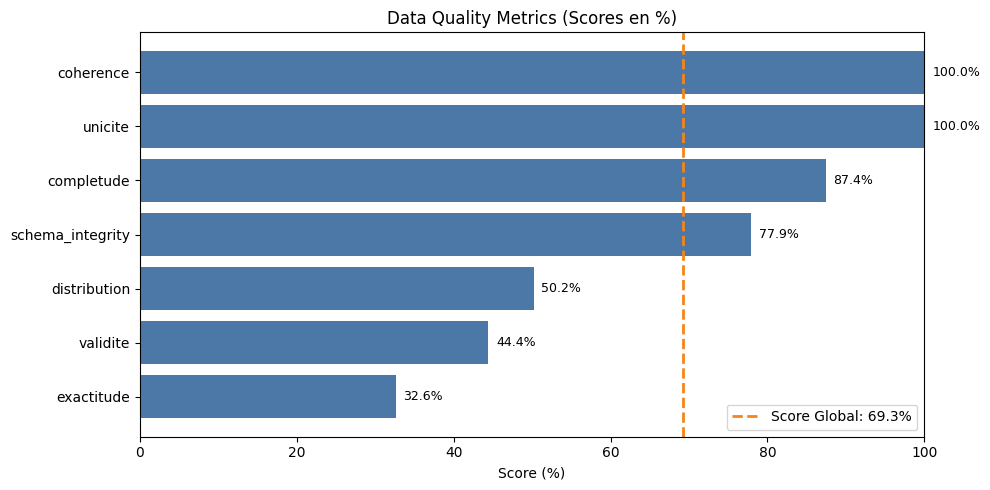

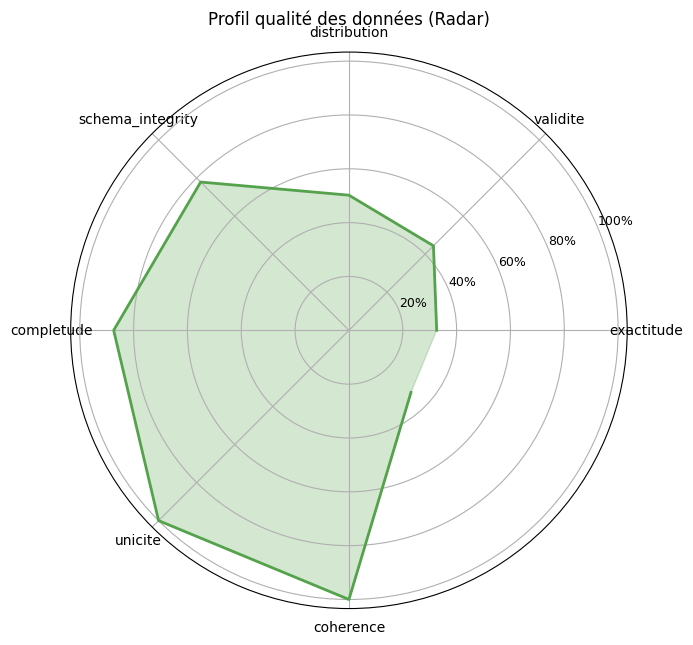

In [17]:

# ...existing code...
import matplotlib.pyplot as plt
import numpy as np

# --- Prepare data (0..1 -> %) and separate global score ---
plot_df = rapport_dq.copy()
plot_df["Score_pct"] = (plot_df["Score"] * 100).round(1)

global_pct = None
if "Score Global" in plot_df.index:
    global_pct = float(plot_df.loc["Score Global", "Score_pct"])
    plot_df = plot_df.drop(index="Score Global")

# Sort for readability
plot_df = plot_df.sort_values("Score_pct", ascending=True)

# =========================
# 1) Horizontal bar chart
# =========================
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.barh(plot_df.index, plot_df["Score_pct"], color="#4C78A8")

ax.set_xlim(0, 100)
ax.set_xlabel("Score (%)")
ax.set_title("Data Quality Metrics (Scores en %)")

# value labels
for b in bars:
    w = b.get_width()
    ax.text(w + 1, b.get_y() + b.get_height()/2, f"{w:.1f}%", va="center", fontsize=9)

# show global score as reference line (if available)
if global_pct is not None:
    ax.axvline(global_pct, color="#F58518", linestyle="--", linewidth=2, label=f"Score Global: {global_pct:.1f}%")
    ax.legend(loc="lower right")

plt.tight_layout()
plt.show()

# =========================
# 2) Radar chart (optional)
# =========================
labels = plot_df.index.tolist()
values = (plot_df["Score_pct"].values / 100.0).tolist()  # back to 0..1 for radar

# close the loop
labels_r = labels + [labels[0]]
values_r = values + [values[0]]

angles = np.linspace(0, 2*np.pi, len(labels_r), endpoint=False)

fig = plt.figure(figsize=(7, 7))
ax = plt.subplot(111, polar=True)

ax.plot(angles, values_r, color="#54A24B", linewidth=2)
ax.fill(angles, values_r, color="#54A24B", alpha=0.25)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=10)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(["20%", "40%", "60%", "80%", "100%"], fontsize=9)
ax.set_title("Profil qualité des données (Radar)", pad=20)

plt.tight_layout()
plt.show()
# ...existing code...


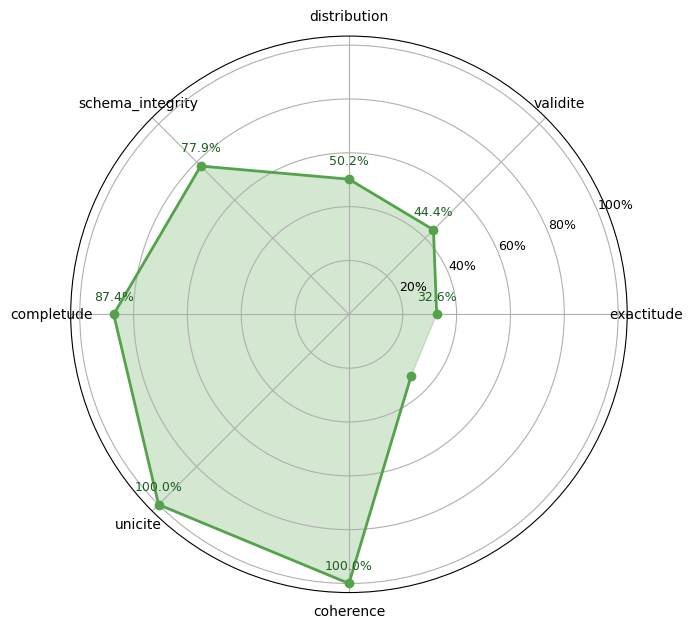

In [20]:
# ...existing code...

# =========================
# 2) Radar chart (optional)
# =========================
labels = plot_df.index.tolist()
values = (plot_df["Score_pct"].values / 100.0).tolist()  # 0..1 for radar

# close the loop
labels_r = labels + [labels[0]]
values_r = values + [values[0]]

angles = np.linspace(0, 2*np.pi, len(labels_r), endpoint=False)

fig = plt.figure(figsize=(7, 7))
ax = plt.subplot(111, polar=True)

ax.plot(angles, values_r, color="#54A24B", linewidth=2, marker="o")
ax.fill(angles, values_r, color="#54A24B", alpha=0.25)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=10)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(["20%", "40%", "60%", "80%", "100%"], fontsize=9)

# ---- Add value label at each point (excluding the duplicated last point)
for ang, val in zip(angles[:-1], values):
    txt = f"{val*100:.1f}%"
    # small offset so text doesn't overlap the marker
    ax.annotate(
        txt,
        xy=(ang, val),
        xytext=(0, 8),
        textcoords="offset points",
        ha="center",
        va="bottom",
        fontsize=9,
        color="#1B5E20"
    )

plt.tight_layout()
plt.show()

# ...existing code...